# Week 6: PCA

**The exercise of this week is about PCA. First load the following libraries that will be necessary.**

In [3]:
!pip install scipy
!pip install scikit-image
#!unzip ./dataset.zip

In [5]:
%matplotlib inline
from skimage.io import imread
from scipy import signal,ndimage
import numpy as np
import time
import scipy.io as sio
from matplotlib.pyplot import imshow,show,figure
import skimage.transform as tf
import IPython
import scipy
from sys import getsizeof
def make_grid(image_list,rows=5):
    cols = len(image_list)//rows
    row_image_list = []
    for c in range(cols):
        col_image_list = []
        for r in range(rows):
            col_image_list.append(image_list[c*rows+r])
        col_image = np.concatenate(col_image_list,axis=0)
        row_image_list.append(col_image)
    return np.concatenate(row_image_list,axis=1)

# Load images

We use the AT&T dataset, which consists of 40 people with 10 experssions each. We split the dataset into two parts, training images and test images. The training images will be used to extract the eigenfaces, which are then used to compress test images.

**First, we load the training data.** Here we take 5 expressions of 20 people as training set. 

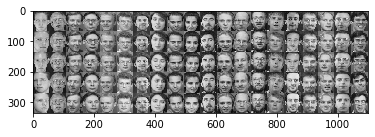

In [70]:
train_person_ids = np.arange(1,21)
train_expression_ids = np.arange(1,6)
train_image_list = []
for pid in train_person_ids:
    for eid in train_expression_ids:
        image = imread('dataset/s%d/%d.pgm'%(pid,eid))/255.
        image = tf.rescale(image,0.6)
        h,w = image.shape
        train_image_list.append(image)

train_image_collage = make_grid(train_image_list,rows=5)
imshow(train_image_collage,cmap='gray')

**Then we load the test images.** To see if the method can deal with unseen people and unseen expressions, we test with the rest 5 expressions of the rest 20 people.

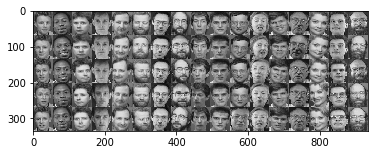

In [71]:
test_person_ids = np.arange(21,38)
test_expression_ids = np.arange(6,11)
test_image_list = []
for pid in test_person_ids:
    for eid in test_expression_ids:
        image = imread('dataset/s%d/%d.pgm'%(pid,eid))/255.
        image = tf.rescale(image,0.6)
        h,w = image.shape
        test_image_list.append(image)
        
test_image_collage = make_grid(test_image_list,rows=5)
imshow(test_image_collage,cmap='gray')

## Part A: Image Compression

In part A, we will use PCA to compress face images. For convenience we reshape the N training images into vectors of length $D = Height\times Width$ and concatenate all vectors to form a $N \times D$ matrix $X$.

In [72]:
image_vectors = [image.flatten() for image in train_image_list]
X = np.stack(image_vectors,axis=1)
print(X.shape)

(3685, 100)


**Compute the mean and covariance of images.** The mean of images $\mu$ is a vector of length $D$ and can be visaulized as an image. The covariance $\Sigma$ is a $D \times D$ matrix. You can use `numpy.mean()` and `numpy.cov()` for the computation.

(3685,)
(3685, 3685)


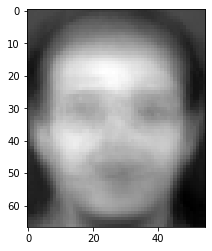

In [67]:
mean = np.mean(X, axis=1)
print(mean.shape)

covariance = np.cov(X)
print(covariance.shape)

imshow(mean.reshape(h,w),cmap='gray')

**Compute eigenfaces.** Eigenfaces are the eigenvectors correponding to k-largest eigenvalues of covariance matrix. You can use `scipy.sparse.linalg.eigs(mat,k)` to compute $k$ largest eigenvalues of $mat$ and corresponding eigenvectors $[v_1...v_k]$ . Note that this function returns complex valued results, which needs to be converted to real numbers using `numpy.real()`.

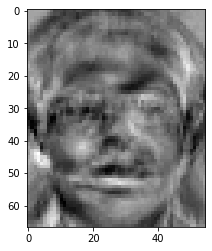

In [112]:
n_eigenfaces = 20
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(covariance, n_eigenfaces)

# Complex2Real
eigenvectors = eigenvectors.real

for i in range(eigenvectors.shape[1]):
    imshow(eigenvectors[:,i].reshape(h,w),cmap='gray')    
    IPython.display.clear_output(True)
    show()
    

**Now we can use the computed eigenfaces to compress images.** Face images can be approximated by linear combinations of eigenfaces $x=\mu + \alpha_1v_1 + \alpha_2v_2 + .... + \alpha_kv_k$. Therefore, we can use the weights $[\alpha_1 ... \alpha_k]$ to record a image, instead of saving all pixels values. Each weight $\alpha_i$ is the projection of the normalized image $\tilde{x} = x-\mu$ onto the corresponding eigenface $v_i$, which can be computed by dot product $\alpha_i = v_i \cdot \tilde{x} $. 

To recover a image from its compression we can use  $x=\mu + \alpha_1v_1 + \alpha_2v_2 + .... + \alpha_kv_k$.


**Complete the lines below to compress a image into a $k$ dimensional vector.**

**Q:** Compress training images and test images. On which set the method works better? Why?

**Q:** Compress image with different number of eigenfaces. What's the influence of $k$?
**A:** Less precise representation of the original image after decompression. Smaller compression size...

**Q:** Considering that we want to reduce data size, what is the maximum value of $k$?

In [131]:
# Covariance from Eigenvectors
eigenvalues_diagonal = np.diag(eigenvalues)
cov_from_decomposition = eigenvectors @ eigenvalues_diagonal @ eigenvectors.T

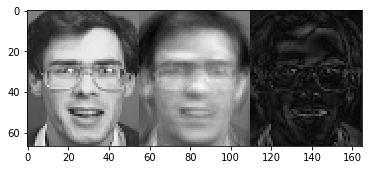

Size before compression: 29480 Bytes
Size after compression: 160 Bytes
15.61887143717262


In [132]:
error_images = []
for image in train_image_list[:]:
    
    # Compress (create weights / alphas)
    normalized_image = image.flatten() - mean
    compressed_image = eigenvectors.T @ normalized_image
    
    # Decompress by multiplying with eigenvectors and adding the mean value
    decompressed_image = eigenvectors @ compressed_image
    decompressed_image = decompressed_image.flatten() + mean
    
    error_image = np.abs(decompressed_image - image.flatten())
    error_images.append(error_image)

    imshow(np.concatenate([image.reshape(h,w),\
                          decompressed_image.reshape(h,w),\
                          error_image.reshape(h,w)],axis=-1),cmap='gray')

    IPython.display.clear_output(True)
    show()
    
print('Size before compression: %d Bytes'%image.nbytes)
print('Size after compression: %d Bytes'%compressed_image.nbytes)
           
error_images = np.stack(error_images,0)
ssd_error = (error_images**2).sum(-1).mean()
print(ssd_error)

# Part B: Face Detection with PCA
**In this part we will use PCA to detect faces.** In previous part, we have implemented a compressor for face images. Since the eigenvectors are extracted from faces images, we can expect that such a compressor would fail on other images, leading to erroneous decompression. This fact can be used for face detection.

You are given an image with a face and your task is to find the location (x coordinate) of the face.
Try to compress and then decompress each part of the image using the method in part A, and then compute the squared error $e = \|x - x_{decompressed}\|_2$. Based on the squared error, find the localtion (x coordinate) where the face is located.

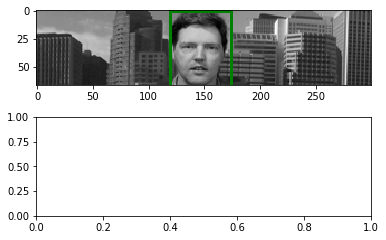

In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image = imread('FaceDetection.bmp')[:h,:]/255.
h_,w_ = image.shape

errors = []

# iterate over each part of the image
for x in range(w_-w):
    
    image_crop = image[:,x:x+w].flatten()
    
    # Compress
    centered_image_crop = image_crop - mean
    compressed_image = eigenvectors.T @ centered_image_crop

    # Decompress
    decompressed_image = eigenvectors @ compressed_image
    decompressed_image = decompressed_image.flatten() + mean
    error = np.sum((decompressed_image - image_crop)**2)
    
    errors.append(error)
    fig, ax = plt.subplots(2,1)
    rect = patches.Rectangle((x,0),w,h,linewidth=3,edgecolor='r',facecolor='none')
    ax[0].imshow(image,cmap='gray')
    ax[0].add_patch(rect)
    ax[1].plot(np.arange(x+1)+w//2,np.array(errors))
    ax[1].set_xlim([0,w_])
    IPython.display.clear_output(True)
    show()

x_best = np.argmin(errors)
fig, ax = plt.subplots(2,1)
rect = patches.Rectangle((x_best,0),w,h,linewidth=3,edgecolor='g',facecolor='none')

ax[0].imshow(image,cmap='gray')
ax[0].add_patch(rect)
IPython.display.clear_output(True)
show()